In [1]:
# Code for profiling the performance of attention

import torch
import torch.nn as nn
import time
import torchvision.models as models
from torch.profiler import profile, record_function, ProfilerActivity
from fvcore.nn import FlopCountAnalysis
import torchprofile
import tracemalloc

input_lengths = [10, 100, 1000, 10000]#, 100000]
devices = ['cpu', 'cuda']
dim = 512

class AttentionModel(nn.Module):
    def __init__(self):
        super(AttentionModel, self).__init__()
        self.Q = nn.Linear(dim, dim)
        self.K = nn.Linear(dim, dim)
        self.V = nn.Linear(dim, dim)
        self.softmax = nn.Softmax(dim=2)

    def forward(self, input):
        return self.softmax((self.Q(input) @ self.K(input).transpose(1, 2)) / (dim ** 0.5)) @ self.V(input)


def attn_profiler(input_length, device='cpu'):
    device = torch.device(device)

    # Randomly sample words for the input sentence
    input = torch.randn(1, input_length, dim).to(device)
    model = AttentionModel().to(device)

    with torch.profiler.profile(
            activities=[
                torch.profiler.ProfilerActivity.CPU,
                torch.profiler.ProfilerActivity.CUDA],
            profile_memory=True,   
            record_shapes=True) as prof:
        start = time.time()
        model(input)
        end = time.time()

    stats = prof.key_averages()
    cuda_memory_usage = sum([s.cuda_memory_usage for s in stats if s.cuda_memory_usage > 0])
    cpu_memory_usage = sum([s.cpu_memory_usage for s in stats if s.cpu_memory_usage > 0])
    memory_usage = cuda_memory_usage if device == torch.device('cuda') else cpu_memory_usage
    
    runtime = end - start
    flop_counter = FlopCountAnalysis(model, input)
    flops = flop_counter.total()
    
    print(f"Device: {device}, Input length: {input_length}, Time: {runtime:.2e}, FLOPS: {flops:.2e}, Memory: {memory_usage:.2e}")

    # del model

    return {
        "input_length": input_length,
        "device": device,
        "time": runtime,
        "flops": flops,
        "memory": memory_usage,        
    }


f:\Programs\anaconda3\envs\ssm_hw5\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 3.56e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 5.42e-02, FLOPS: 1.10e+11, Memory: 2.19e+09
Device: cpu, Input length: 10, Time: 1.52e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 4.07e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 2.55e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.52e-03, FLOPS: 8.89e+07, Memory: 1.84e+06


Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 1000, Time: 3.64e-02, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.53e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.84e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.54e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 2.54e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.52e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.05e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.53e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 7.13e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.52e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.47e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.53e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 2.54e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.02e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 9.79e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.42e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.01e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.52e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.01e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 2.54e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.02e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 6.10e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.52e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.41e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.54e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.56e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.01e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 7.12e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.01e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.36e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.03e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.53e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.55e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.02e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 6.61e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.03e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.40e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.52e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.05e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.01e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 7.67e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.01e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.49e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.03e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.52e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.57e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.02e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 6.62e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.43e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.55e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.53e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.56e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.01e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 7.66e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.38e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.54e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.06e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.01e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 8.74e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.42e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.05e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.02e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 8.13e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.43e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09


Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10, Time: 1.53e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.53e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 2.54e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 2.03e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 2.59e-02, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.59e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09


Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10, Time: 2.03e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.53e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.07e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.53e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 3.29e-02, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.53e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.67e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.53e-03, FLOPS: 7.97e+06, Memory: 1.66e+05


Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cuda, Input length: 10, Time: 2.04e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.05e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 2.54e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 2.54e-02, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.60e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 2.54e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.53e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 7.12e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.53e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.44e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.05e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.53e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.01e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 2.54e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.02e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 7.14e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.53e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.41e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.01e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.54e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 2.55e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.01e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 7.16e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.03e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.36e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.53e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 2.87e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.02e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 5.59e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 2.03e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.39e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.04e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.52e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.01e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.06e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.01e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 7.10e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.03e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.35e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.53e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 2.54e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.02e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 6.62e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.52e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.36e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 2.03e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 2.54e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.02e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 6.64e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 2.03e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.44e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.52e-03, FLOPS: 7.97e+06, Memory: 1.66e+05


Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cuda, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 2.54e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.01e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 3.11e-02, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 5.08e-04, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.59e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 5.08e-04, FLOPS: 1.10e+11, Memory: 2.17e+09


Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10, Time: 1.52e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.05e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.01e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 3.11e-02, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.03e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.53e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 2.54e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.02e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 5.60e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.51e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.63e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.52e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 2.54e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.01e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 8.15e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.04e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.44e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.03e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 2.03e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 2.54e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.02e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 6.64e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.43e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.53e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 2.54e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.02e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 7.12e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.36e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.52e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 2.54e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.02e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 6.10e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.40e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.01e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 5.10e-04, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 2.55e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 5.13e-04, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 6.84e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.34e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.52e-03, FLOPS: 7.97e+06, Memory: 1.66e+05


Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cuda, Input length: 10, Time: 1.01e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.06e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.02e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 2.60e-02, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.55e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.53e-03, FLOPS: 7.97e+06, Memory: 1.66e+05


Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cuda, Input length: 10, Time: 1.01e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 2.54e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.53e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 2.81e-02, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.58e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09


Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10, Time: 1.52e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.01e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 2.53e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.02e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 2.63e-02, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.01e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.61e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.53e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 2.54e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.02e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 8.20e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 2.03e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.38e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.03e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.52e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.03e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 2.56e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.01e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 7.65e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.53e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.41e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.53e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.01e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.55e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 5.10e-04, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 8.69e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.42e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 5.00e-04, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.53e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.05e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.01e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 7.16e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.50e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.03e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.03e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 2.03e-03, FLOPS: 7.97e+06, Memory: 1.66e+05


Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 100, Time: 2.54e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.02e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 2.96e-02, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 5.12e-04, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.51e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 5.10e-04, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.52e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.01e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 2.54e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.01e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 6.62e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.49e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 2.03e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.05e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 2.03e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 7.13e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.40e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.52e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.06e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 2.03e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 6.12e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 2.03e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.39e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 5.06e-04, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.53e-03, FLOPS: 7.97e+06, Memory: 1.66e+05


Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cuda, Input length: 10, Time: 1.01e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 2.54e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.02e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 2.95e-02, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.03e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.57e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.01e-03, FLOPS: 7.97e+06, Memory: 1.66e+05


Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cuda, Input length: 10, Time: 1.53e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.06e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.02e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 2.65e-02, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.59e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 5.06e-04, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 2.03e-03, FLOPS: 7.97e+06, Memory: 1.66e+05


Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cuda, Input length: 10, Time: 1.06e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 2.03e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.52e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 2.75e-02, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.01e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.57e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09


Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10, Time: 1.52e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 2.03e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 2.55e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.02e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 2.56e-02, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 2.07e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.57e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 5.10e-04, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.53e-03, FLOPS: 7.97e+06, Memory: 1.66e+05


Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cuda, Input length: 10, Time: 1.01e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.05e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.53e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 2.96e-02, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.00e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.58e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.52e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.03e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.07e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.53e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 6.63e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.44e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.53e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.06e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 2.55e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 7.66e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.37e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.53e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.56e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 2.63e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 6.62e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.40e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.01e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.58e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 2.03e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 7.67e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 2.03e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.36e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09


Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10, Time: 1.53e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.56e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 2.04e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 3.07e-02, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.55e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09


Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10, Time: 1.54e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.05e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.07e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 2.79e-02, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.03e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.58e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 5.36e-04, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 2.04e-03, FLOPS: 7.97e+06, Memory: 1.66e+05


Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cuda, Input length: 10, Time: 1.01e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.06e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.02e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 2.90e-02, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.65e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.53e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.55e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.05e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.02e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 7.66e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.36e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.52e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.52e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 2.55e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.02e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 6.12e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.54e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.41e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 5.11e-04, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.52e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.52e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.06e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.02e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 6.63e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.53e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.34e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.53e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 2.55e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.02e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 6.13e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.01e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.38e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.01e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.01e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 2.54e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.01e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 7.14e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.03e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.43e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.52e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.01e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 2.55e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.02e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 6.62e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.51e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.53e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 2.55e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.02e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 7.14e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.56e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.35e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.03e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 2.55e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.02e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 6.11e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.37e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.03e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.01e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.06e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.01e-03, FLOPS: 8.89e+07, Memory: 1.84e+06


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 1000, Time: 2.78e-02, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.03e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.59e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.52e-03, FLOPS: 7.97e+06, Memory: 1.66e+05


Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cuda, Input length: 10, Time: 2.03e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.04e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 2.03e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 2.49e-02, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.57e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.52e-03, FLOPS: 7.97e+06, Memory: 1.66e+05


Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cuda, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 2.54e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.02e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 2.95e-02, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.61e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.03e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.53e-03, FLOPS: 7.97e+06, Memory: 1.66e+05


Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cuda, Input length: 10, Time: 1.01e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.03e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 5.09e-04, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 3.56e-02, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.58e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.01e-03, FLOPS: 1.10e+11, Memory: 2.17e+09


Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10, Time: 1.53e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.52e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.05e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.01e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 2.95e-02, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.57e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 5.07e-04, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 2.54e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 5.14e-04, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 7.14e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.03e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.37e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.06e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.02e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 7.15e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.39e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.01e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.05e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 5.09e-04, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 7.11e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.43e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 5.09e-04, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.54e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.01e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 2.55e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.02e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 8.19e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.01e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.34e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 5.16e-04, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.53e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 2.55e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.01e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 7.12e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.40e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.54e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 2.56e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.01e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 8.15e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.05e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.40e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.03e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.52e-03, FLOPS: 7.97e+06, Memory: 1.66e+05


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cuda, Input length: 10, Time: 5.08e-04, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.06e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.02e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 2.63e-02, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.03e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.60e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 5.15e-04, FLOPS: 1.10e+11, Memory: 2.17e+09


Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10, Time: 1.52e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.53e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.07e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.02e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 2.70e-02, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.03e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.62e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.03e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05


Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cuda, Input length: 10, Time: 1.01e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 2.54e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.02e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 2.34e-02, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.01e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.60e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.52e-03, FLOPS: 7.97e+06, Memory: 1.66e+05


Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cuda, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.29e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.02e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 2.75e-02, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.52e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 5.09e-04, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.53e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.05e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.01e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 6.11e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.42e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.52e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 2.55e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.53e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 7.66e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.53e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.30e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.53e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.56e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.01e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 6.63e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.03e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.37e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.03e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.54e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.01e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.56e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.02e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 8.15e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.54e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.47e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.52e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.01e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 4.07e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.01e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 7.63e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.41e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.54e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 5.11e-04, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 2.55e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.02e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 7.65e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.01e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.39e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 5.10e-04, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.52e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.01e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.57e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.02e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 7.68e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.37e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 5.08e-04, FLOPS: 1.10e+11, Memory: 2.17e+09


Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10, Time: 1.53e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 2.54e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.56e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.01e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 3.11e-02, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.58e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 5.07e-04, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.53e-03, FLOPS: 7.97e+06, Memory: 1.66e+05


Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cuda, Input length: 10, Time: 1.01e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.05e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.01e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 2.54e-02, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.58e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09


Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10, Time: 1.52e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.06e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.01e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 2.94e-02, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.56e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.59e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.53e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.56e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.01e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 6.62e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.40e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.54e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 4.07e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.53e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 8.16e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.38e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.52e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.01e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.56e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 2.54e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 6.12e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.42e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.54e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 2.04e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 2.03e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.09e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.53e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 8.67e-03, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 2.03e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.71e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.01e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.53e-03, FLOPS: 7.97e+06, Memory: 1.66e+05


Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cuda, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 2.02e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.02e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 3.06e-02, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.60e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09


Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10, Time: 1.53e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.54e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 2.55e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.02e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 2.80e-02, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.57e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 5.14e-04, FLOPS: 1.10e+11, Memory: 2.17e+09


Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10, Time: 1.54e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.53e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.63e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.53e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 3.17e-02, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.01e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.59e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.03e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.53e-03, FLOPS: 7.97e+06, Memory: 1.66e+05


Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cuda, Input length: 10, Time: 1.52e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 2.54e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.53e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 3.31e-02, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.59e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.52e-03, FLOPS: 7.97e+06, Memory: 1.66e+05


Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cuda, Input length: 10, Time: 1.01e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 2.53e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.02e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 2.63e-02, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.56e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.04e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.53e-03, FLOPS: 7.97e+06, Memory: 1.66e+05


Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cuda, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 2.04e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 5.11e-04, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 2.81e-02, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.55e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09


Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10, Time: 1.52e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.01e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.05e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.02e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 2.56e-02, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.60e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09


Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10, Time: 2.05e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cuda, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.07e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.02e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 2.80e-02, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 2.04e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.59e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.03e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.53e-03, FLOPS: 7.97e+06, Memory: 1.66e+05


Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cuda, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 2.54e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 2.03e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 2.67e-02, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.02e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.63e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.52e-03, FLOPS: 7.97e+06, Memory: 1.66e+05


Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cuda, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 2.54e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.02e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 2.65e-02, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 1.60e-03, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.57e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 5.08e-04, FLOPS: 1.10e+11, Memory: 2.17e+09
Device: cpu, Input length: 10, Time: 1.02e-03, FLOPS: 7.97e+06, Memory: 1.66e+05


Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cuda, Input length: 10, Time: 1.01e-03, FLOPS: 7.97e+06, Memory: 1.66e+05
Device: cpu, Input length: 100, Time: 3.56e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cuda, Input length: 100, Time: 1.02e-03, FLOPS: 8.89e+07, Memory: 1.84e+06
Device: cpu, Input length: 1000, Time: 2.55e-02, FLOPS: 1.81e+09, Memory: 3.64e+07
Device: cuda, Input length: 1000, Time: 5.39e-04, FLOPS: 1.81e+09, Memory: 3.69e+07


Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)
Unsupported operator aten::div encountered 1 time(s)
Unsupported operator aten::softmax encountered 1 time(s)


Device: cpu, Input length: 10000, Time: 2.61e-01, FLOPS: 1.10e+11, Memory: 2.16e+09
Device: cuda, Input length: 10000, Time: 1.02e-03, FLOPS: 1.10e+11, Memory: 2.17e+09


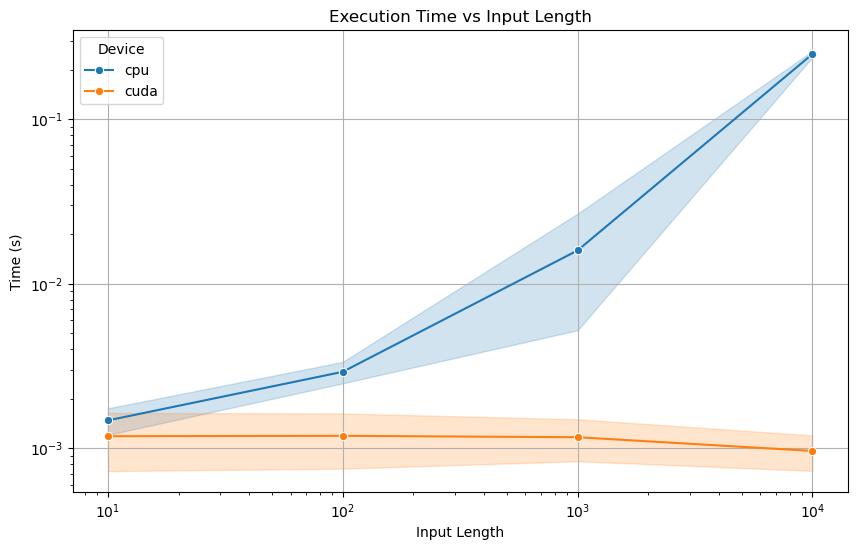

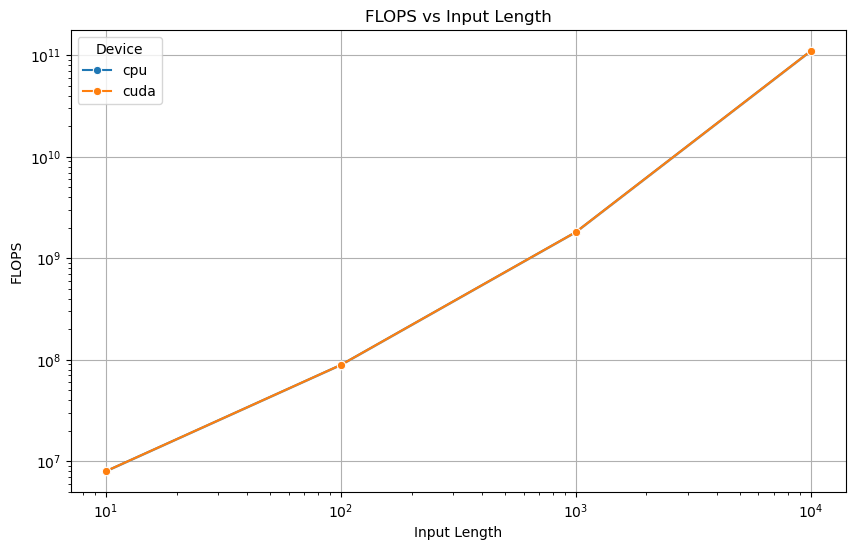

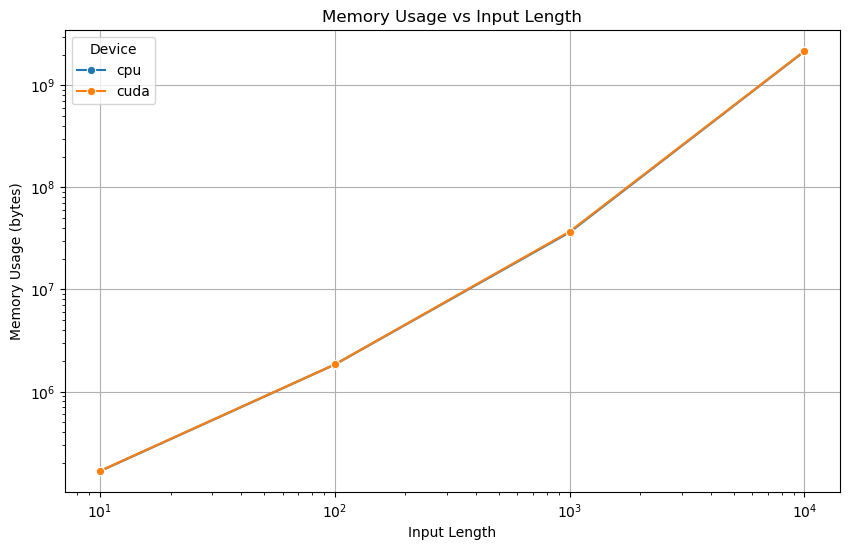

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Do a warmup run 
attn_profiler(10000)
attn_profiler(10000, 'cuda')

# Initialize lists to store results
results = []

# Run the profiler 100 times for each input length and device, and store the results
for i in range(100):
    for input_length in input_lengths:
        for device in devices:
            result = attn_profiler(input_length, device)  # Result is a dictionary
            results.append(result)  # Append the whole result dictionary to the list

# Convert the list of dictionaries to a DataFrame
df = pd.DataFrame(results)

# Plotting time, FLOPS, and memory separately with error bars
metrics = ['time', 'flops', 'memory']
titles = {
    'time': 'Execution Time vs Input Length',
    'flops': 'FLOPS vs Input Length',
    'memory': 'Memory Usage vs Input Length'
}
y_labels = {
    'time': 'Time (s)',
    'flops': 'FLOPS',
    'memory': 'Memory Usage (bytes)'
}

# Plot each metric
for metric in metrics:
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=df,
        x='input_length', 
        y=metric, 
        hue='device', 
        errorbar='sd',  
        marker='o'
    )
    
    plt.title(titles[metric])
    plt.xlabel('Input Length')
    plt.ylabel(y_labels[metric])
    plt.xscale('log')  
    plt.yscale('log')
    plt.legend(title='Device')
    plt.grid(True)
    plt.show()